In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import os
import pickle as pck
import numpy as np
import pandas as pd

from skimage import feature, exposure, transform, io

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
import tensorflow

Using TensorFlow backend.


In [3]:
#probando
np.random.seed(40)
tensorflow.set_random_seed(40)

In [4]:
dir_train = 'imagenes_color/train/'
dir_test = 'imagenes_color/test/'
path_validar = 'imagenes_color/validar/'

In [5]:
#estilos = ['realism', 'surrealism', 'abstract-art', 'pop-art']
estilos = ['abstract-art', 'realism'] # Probando con dos estilos
num_estilos = len(estilos)
estilos_dict = {
    'abstract-art' : 0,
    'realism' : 1 
}

In [6]:
images_train = []
for e in estilos:
    archivos = os.listdir(os.path.join(dir_train, e))
    for archivo in archivos:
        images_train += [(os.path.join(e, archivo), e)]

In [7]:
images_test = []
for e in estilos:
    archivos = os.listdir(os.path.join(dir_test, e))
    for archivo in archivos:
        images_test += [(os.path.join(e, archivo), e)]

In [8]:
print('Imágenes para train: {} \nImágenes para test: {}'.format(len(images_train), len(images_test)))

Imágenes para train: 1186 
Imágenes para test: 236


In [30]:
def carga_imagenes(xy, carpeta):
    indices = np.arange(len(xy))
    np.random.shuffle(indices)
    
    X = []
    y = []
    samples = len(indices)

    for i in range(samples):
        t = xy[indices[i]]
        #print(t)
        try:
            img = io.imread(os.path.join(carpeta, t[0]))
            img = transform.resize(img, (64, 64, 1), mode = 'reflect')
            X += [img]
            y_tmp = [0 for _ in range(num_estilos)]
            y_tmp[estilos_dict[t[1]]] = 1
            y += [y_tmp]
        except OSError:
            pass



    X = np.array(X)
    y = np.array(y)
    
    return X, y



In [31]:
X_train, y_train = carga_imagenes(images_train, dir_train)

In [32]:
X_test, y_test = carga_imagenes(images_test, dir_test)

In [33]:
len(X_train)

1186

In [34]:
X_train.shape

(1186, 64, 64, 1)

In [25]:
# Prepare data to feed the NN
img_rows, img_cols = 64, 64


# Ask keras which format to use depending on used backend and arrange data as expected
if K.image_data_format() == 'channels_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# Incoming data is in uint8. Cast the input data images to be floats in range [0.0-1.0]  
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_estilos)
y_test = keras.utils.to_categorical(y_test, num_estilos)


x_train shape: (1186, 64, 64, 1)
x_test shape: (236, 64, 64, 1)
1186 train samples
236 test samples


In [26]:
type(X_train)

numpy.ndarray

In [ ]:
# Se almacenan los datos preparados para el entrenamiento

In [ ]:
with open('data/X_train', 'wb') as file:
    pck.dump(X_train, file) 

In [ ]:
with open('data/y_train', 'wb') as file:
    pck.dump(y_train, file) 

In [ ]:
with open('data/X_test', 'wb') as file:
    pck.dump(X_test, file) 

In [ ]:
with open('data/y_test', 'wb') as file:
    pck.dump(y_test, file) 

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    horizontal_flip = True)

train_datagen.fit(X_train)

In [16]:
width = 64
height = 64
n_channels = 1

In [35]:
# CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=5, input_shape=(width, height, n_channels), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(48, kernel_size=3, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(64, activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(num_estilos, activation = 'softmax'))


model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [36]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32)

In [37]:
training_result = model.fit_generator(generator=train_generator,
                                      validation_data = (X_test, y_test),
                                      epochs = 5,
                                      verbose = 1,
                                      steps_per_epoch = len(X_train) / 32)

Epoch 1/5
38/37 [==============================] - 2s 62ms/step - loss: 0.6995 - acc: 0.5844 - val_loss: 1.3233 - val_acc: 0.4958
Epoch 2/5
38/37 [==============================] - 2s 47ms/step - loss: 0.6372 - acc: 0.6448 - val_loss: 0.5487 - val_acc: 0.7203
Epoch 3/5
38/37 [==============================] - 2s 48ms/step - loss: 0.5872 - acc: 0.7062 - val_loss: 0.5665 - val_acc: 0.7161
Epoch 4/5
38/37 [==============================] - 2s 48ms/step - loss: 0.5695 - acc: 0.7148 - val_loss: 1.1130 - val_acc: 0.5085
Epoch 5/5
38/37 [==============================] - 2s 48ms/step - loss: 0.5458 - acc: 0.7312 - val_loss: 0.6482 - val_acc: 0.6568


In [ ]:
# habría que pararlo cuando vuelve a bajar .....

In [38]:
# CNN 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(48, kernel_size=3, activation = 'relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Dense(num_estilos, activation = 'softmax'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_estilos, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [40]:
training_result = model.fit_generator(generator=train_generator,
                                      validation_data = (X_test, y_test),
                                      epochs = 35,
                                      verbose = 1,
                                      steps_per_epoch = len(X_train) / 32)

Epoch 1/35
38/37 [==============================] - 6s 154ms/step - loss: 0.6303 - acc: 0.6453 - val_loss: 0.6046 - val_acc: 0.6907
Epoch 2/35
38/37 [==============================] - 7s 194ms/step - loss: 0.6257 - acc: 0.6547 - val_loss: 0.6195 - val_acc: 0.6695
Epoch 3/35
38/37 [==============================] - 7s 193ms/step - loss: 0.6481 - acc: 0.6353 - val_loss: 0.6006 - val_acc: 0.6737
Epoch 4/35
38/37 [==============================] - 7s 193ms/step - loss: 0.6307 - acc: 0.6572 - val_loss: 0.6021 - val_acc: 0.6737
Epoch 5/35
38/37 [==============================] - 7s 193ms/step - loss: 0.5982 - acc: 0.6848 - val_loss: 0.5910 - val_acc: 0.6992
Epoch 6/35
38/37 [==============================] - 7s 192ms/step - loss: 0.6280 - acc: 0.6506 - val_loss: 0.6049 - val_acc: 0.6822
Epoch 7/35
38/37 [==============================] - 7s 192ms/step - loss: 0.5964 - acc: 0.6852 - val_loss: 0.5707 - val_acc: 0.7288
Epoch 8/35
38/37 [==============================] - 7s 193ms/step - loss: 0.

In [41]:
# CNN 3

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_estilos, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [42]:
batch_size = 40
epochs = 50

In [43]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32)

training_result = model.fit_generator(generator=train_generator,
                                      validation_data = (X_test, y_test),
                                      epochs = 5,
                                      verbose = 1,
                                      steps_per_epoch = len(X_train) / 2)

Epoch 1/5
593/593 [==============================] - 142s 240ms/step - loss: 0.4837 - acc: 0.7797 - val_loss: 0.3310 - val_acc: 0.8686
Epoch 2/5
593/593 [==============================] - 141s 237ms/step - loss: 0.3540 - acc: 0.8519 - val_loss: 0.4399 - val_acc: 0.8051
Epoch 3/5
593/593 [==============================] - 140s 237ms/step - loss: 0.2938 - acc: 0.8788 - val_loss: 0.3732 - val_acc: 0.8686
Epoch 4/5
593/593 [==============================] - 140s 235ms/step - loss: 0.2390 - acc: 0.9077 - val_loss: 0.4781 - val_acc: 0.8136
Epoch 5/5
593/593 [==============================] - 141s 238ms/step - loss: 0.1927 - acc: 0.9269 - val_loss: 0.4355 - val_acc: 0.8475


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

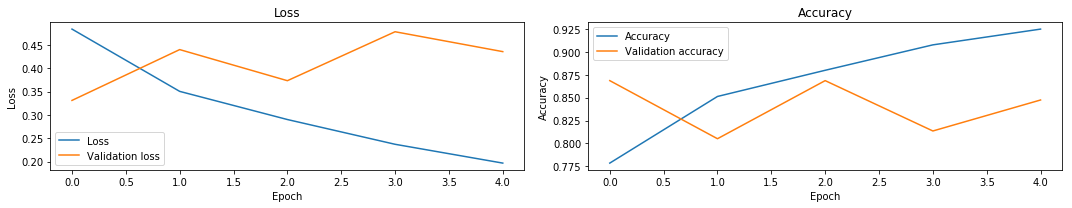

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(training_result.history['loss'], label="Loss")
axes[0].plot(training_result.history['val_loss'], label="Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(training_result.history['acc'], label="Accuracy")
axes[1].plot(training_result.history['val_acc'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [45]:
batch_size = 20
epochs = 10

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test))

Train on 1186 samples, validate on 236 samples
Epoch 1/10
1186/1186 [==============================] - 9s 8ms/step - loss: 0.1288 - acc: 0.9444 - val_loss: 0.6104 - val_acc: 0.8559
Epoch 2/10
1186/1186 [==============================] - 10s 8ms/step - loss: 0.1521 - acc: 0.9427 - val_loss: 0.3463 - val_acc: 0.8814
Epoch 3/10
1186/1186 [==============================] - 10s 9ms/step - loss: 0.0575 - acc: 0.9823 - val_loss: 0.4380 - val_acc: 0.8856
Epoch 4/10
1186/1186 [==============================] - 10s 9ms/step - loss: 0.0731 - acc: 0.9722 - val_loss: 0.3996 - val_acc: 0.9110
Epoch 5/10
1186/1186 [==============================] - 10s 9ms/step - loss: 0.0387 - acc: 0.9865 - val_loss: 0.4118 - val_acc: 0.8856
Epoch 6/10
1186/1186 [==============================] - 10s 9ms/step - loss: 0.0304 - acc: 0.9907 - val_loss: 0.4006 - val_acc: 0.8898
Epoch 7/10
1186/1186 [==============================] - 10s 9ms/step - loss: 0.0216 - acc: 0.9949 - val_loss: 0.4854 - val_acc: 0.8898
Epoch 8/1

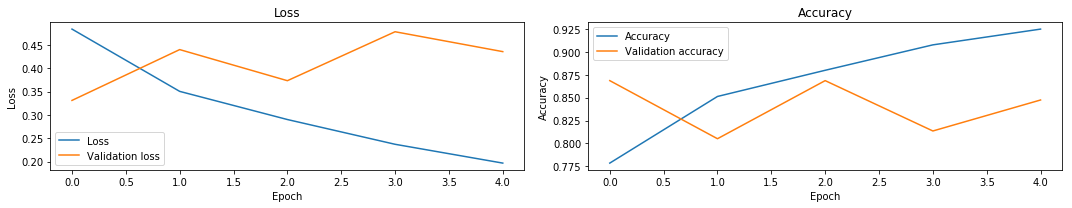

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(training_result.history['loss'], label="Loss")
axes[0].plot(training_result.history['val_loss'], label="Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(training_result.history['acc'], label="Accuracy")
axes[1].plot(training_result.history['val_acc'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [47]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5110648289575415
Test accuracy: 0.8940677976204177
